In [1]:
import numpy as np
import numpy.testing as npt
from scipy.linalg import expm
import matplotlib.pyplot as plt
import scipy.spatial, scipy.linalg
import scipy.sparse.linalg
import pandas as pd
%matplotlib inline

class PCA():
    def __init__(self, X):
        # ...
        self.X = X
        C = np.cov(self.X.T)
        D, U = np.linalg.eig(C)
        idx = np.argsort(-D)
        Ut = U.T
        self.U = Ut[idx]
        self.D = D[idx]

    
    def project(self, m):
        # ...
        U = self.U.T
        M = U[:,:m] 
        Z = np.dot(M.T,self.X.T)
        Z = Z.T 
        Z = Z -np.mean(Z,axis=0)
        return Z
    
    def reconstruct(self, m):
        Z = self.project(m)
        U = self.U.T
        Y = np.dot(U[:,:m],Z.T)
        Y = Y + np.mean(Y,axis=1).reshape(len(Y),1)
        return Y.T

## 3.1 Preprocessing 
(a) Load the dataset pca2.csv. Compute the Principal Components PC1 and PC2 and plot the data in the coordinate system PC1 vs. PC2 – What do you observe?


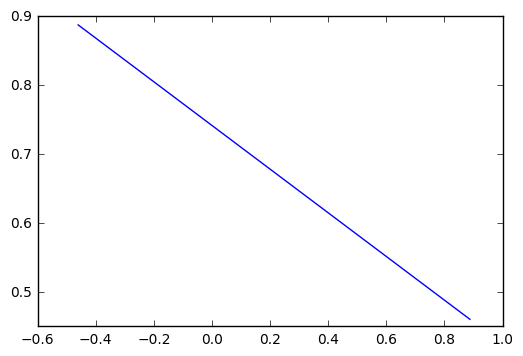

In [2]:
# Load dataset
data = np.loadtxt('pca2.csv', skiprows=1, delimiter=',')
#compute PC and plot
pca2 = PCA(data)
plt.plot(pca2.U[:,0],pca2.U[:,1])

(b) Remove Observations 17 and 157 and redo the first two steps. What is the difference?

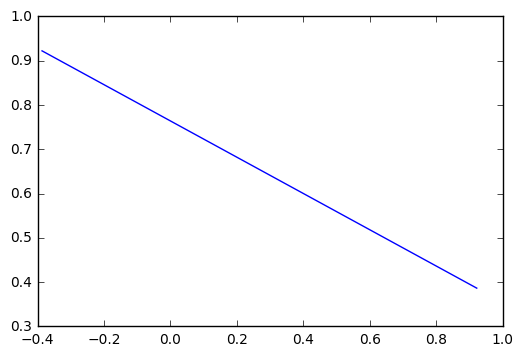

In [3]:
newset = np.delete(data, 16, 0)
newset = np.delete(data, 156, 0)
pca2new = PCA(newset)
plt.plot(pca2new.U[:,0],pca2new.U[:,1])

Slope became slower.

## 3.2 Whitening

(a) Load the dataset pca4.csv and check for outliers in the individual variables.

In [4]:
# Load dataset
data4 = np.loadtxt('pca4.csv', skiprows=1, delimiter=',')
pca4 = PCA(data4)
#Novelty Filter
nov = np.dot(pca4.U[3].reshape(1,4),data4.T)
nov = nov -np.mean(nov)
novar = np.mean(nov**2)
outidx = np.where(nov**2>novar)
print(outidx[1])


[ 17  99 111 199 211 409 472]


(b) Do PCA on a reasonable subset of this data. Use a scree plot to determine how many PCs represent the data well.

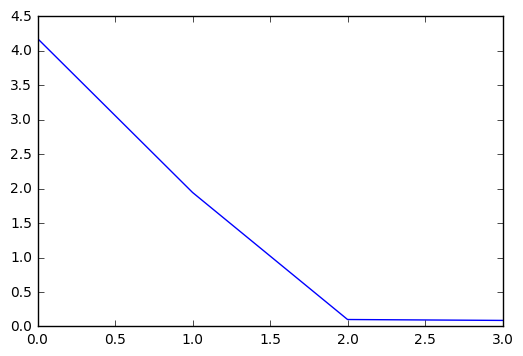

In [5]:
subset = np.delete(data4,outidx[1],0)
newpca4 = PCA(subset)
plt.plot(newpca4.D)

We choose first 2 PCs to represent.

In [6]:
Error = np.linalg.norm(subset -newpca4.reconstruct(2))
print("Error ||subset-represented subset||: ",Error)

Error ||subset-represented subset||:  9.97175530191


(c) “Whiten” the data, i.e. create a set of 4 uncorrelated variables with mean 0 and standard deviation equal to 1. This can be done e.g. using the transformation　
$$ Z = \tilde{X}E\Lambda^{-1/2} $$
The new variables $z_i$ form the columns of Z, E is a matrix containing in its columns the normalized eigenvectors of the covariance matrix C of the centered data $\tilde{X}$ (variables columnwise) and $\Lambda$ is a diagonal matrix containing the corresponding eigenvalues.

In [7]:
cenX = subset - np.mean(subset,axis=0)
C = np.cov(cenX.T)
D,E = np.linalg.eig(C)
nomE = np.empty((4,4))
nomE = E/np.linalg.norm(E,axis=0)
Lambda12 = np.diag(D**(-1/2))
Z = np.dot(np.dot(cenX,nomE),Lambda12)


(d) Make 3 heat plots of the (i) 4x4 covariance matrix C, (ii) the covariance matrix of the data projected onto PC1-PC4, and (iii) of the whitened variables.

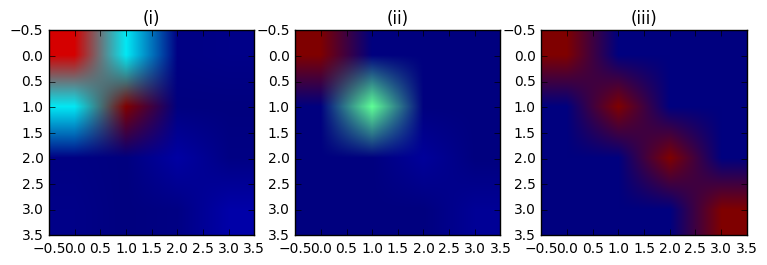

In [8]:
plt.figure(figsize=(9,3))
# 4x4 covariance matrix C
plt.subplot(131)
plt.title("(i)")
plt.imshow(C)
plt.subplot(132)
covpro=np.cov(newpca4.project(4).T)
plt.title("(ii)")
plt.imshow(covpro)
plt.subplot(133)
plt.title("(iii)")
plt.imshow(np.cov(Z.T))

## 3.3 Oja’s Rule: Derivation
Consider a linear connectionist neuron whose output $y = y(t)$ at time $t$ is an inner product of the N-dim input vector $x = x(t)$ with the N-dim weight vector w:
$$ y = w^T x$$

The Hebbian update rule for learning the weights can be written as
$$ w_i(t + 1) = w_i(t) + \epsilon y(t)x_i(t), \:\:\:   i = 1, 2,,,, N $$

where $\epsilon$ is the learning-rate parameter and $t$ the iteration step. As was shown in the lecture, the Hebbian learning rule leads to a divergence of the length of the weight vector. Therefore, the following normalization was introduced by Oja:
$$ w_i(t+1)=\frac{w_i(t) + \epsilon y(t)x_i(t)}{(\sum^{N}_{j=1}[w_j(t)+\epsilon y(t)x_j(t)]^2)^{\frac{1}{2}} }$$

Task: Derive an approximation to this update rule for a small value of the learning-rate parameter $\epsilon$ by Taylor expanding the right hand side of this equation with respect to $\epsilon$ around $\epsilon$ = 0. Show that neglecting terms of second or higher order in $\epsilon$ gives Oja’s rule:
$$ w_i(t + 1)=w_i(t)+ \epsilon y(t)[x_i(t)-y(t)w_i(t)]$$



Anser: The formula of Taylor expanding is
$$\sum^{\infty}_{n=0} \frac{f^{(n)}}{n!} (x-a)^n$$
And 
$$w(t+1) = f(\epsilon)=\frac{w_i(t) + \epsilon y(t)x_i(t)}{(\sum^{N}_{j=1}[w_j(t)+\epsilon y(t)x_j(t)]^2)^{\frac{1}{2}} }$$
$$|w| =\sum^{N}_{j=1}[w_j(t)]^2 =1, \:\:\:  \sum^{N}_{j=0}[x_j(t)w_j(t) ] = y(t) $$

Neglecting terms of second or higher order in  ϵ so we have to expand only until 1st order
\begin{eqnarray}
f^{(0)}(0)+f^{(1)}(0)\epsilon &=& \frac{w_i(t)}{(\sum^{N}_{j}w_j^2(t))^{\frac{1}{2}}} + \epsilon \left( \frac{y(t)x_i(t)}{(\sum^{N}_{j=1}[w_j(t)+0y(t)x_j(t)]^2)^{\frac{1}{2}}}-\frac{1}{2}\frac{w_i(t)+0y(t)x_i(t)}{(\sum^{N}_{j=1}[w_j(t)+0y(t)x_j(t)]^2)^{\frac{3}{2}}} 2 \sum^{N}_{j=0}[y(t)x_j(t)w_j(t)+0y(t)^2x_j(t)^2 ]  \right) \\
&=&\frac{w_i(t)}{(\sum^{N}_{j}w_j^2(t))^{\frac{1}{2}}} + \epsilon \left( \frac{y(t)x_i(t)}{(\sum^{N}_{j=1}[w_j(t)]^2)^{\frac{1}{2}}}-\frac{w_i(t)}{(\sum^{N}_{j=1}[w_j(t)]^2)^{\frac{3}{2}}} y(t) \sum^{N}_{j=0}[x_j(t)w_j(t) ] \right) \\
&=& w_i(t) + \epsilon \left( y(t)x_i(t) - y(t)^2w_i(t) \right) \\
&=& w_i(t) + \epsilon y(t) [(x_i(t) - y(t)w_i(t) ]
\end{eqnarray}


## 3.4 Oja’s Rule: Application
The file data-onlinePCA.txt contains observations from an artificial experiment run over an interval of time (i.e. the first datapoint was observed at $t_0 = 0$ and the last at $t_N = 10s$).

1. Make a scatter plot of the data and indicate the time index by the color of the datapoints you can e.g. break the full dataset into 10 blocks corresponding to 1 second length each and therefore use 10 different colors).
2. Determine the principal components (using batch PCA) and plot the first PC (e.g. as an arrow or the endpoint of it) for each of the 10 blocks in the same plot as the original data. 
3. Implement Oja’s rule and apply it with a learning-rate parameter $ \epsilon \in [0:002, 0:04, 0:45]$ to the dataset. In each iteration randomly sample one data point and apply the learning step. Plot the weights at each timestep (as points whose x vs. y coordinates are given by the weight for x and y) in the same plot as the original data (use the colors from 1. to indicate the time index for each plotted weight). Interpret your results.

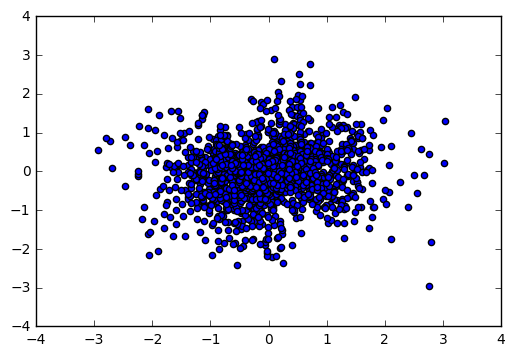

In [9]:
dtonln = np.loadtxt('data-onlinePCA.txt', skiprows=1, delimiter=',',usecols=np.arange(1,3))
plt.scatter(dtonln[:,0],dtonln[:,1])

In [10]:
# Divided by time steps
label = np.empty((10,200))
for i in range(10):
    label[i] =np.ones(200)*i
label = label.reshape(1,2000)

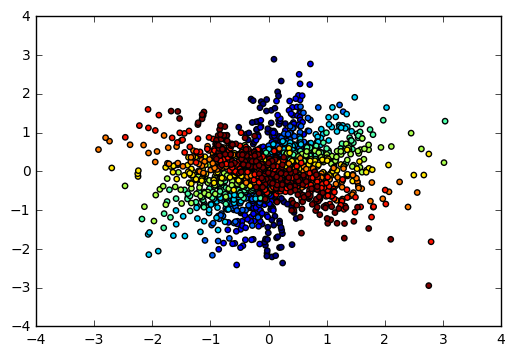

In [11]:
# Make a scatter plot
plt.scatter(dtonln[:,0],dtonln[:,1],15,label[0])

In [33]:
# Determine the principal components 
PCs=np.empty((10,2,2))
X = np.empty((10,200,2))
for i in range(10):
    idx = np.where(label==i)[1]
    X[i] = dtonln[idx]
    opca = PCA(dtonln[idx])
    PCs[i] = opca.U
firstPCs = PCs[:,0,:]


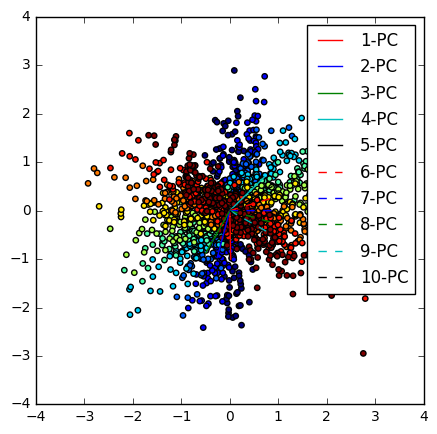

In [37]:
# Plot the first PC (e.g. as an arrow or the endpoint of it) for each of the 10 blocks
plt.figure(figsize=(5,5))
colors = ['r','b','g','c','k','r--','b--','g--','c--','k--',]
for i in range(len(firstPCs)):
    vector = firstPCs[i];
    plt.plot((0,vector[0]),(0,vector[1]), colors[i], label='%d-PC' % (i+1) )
    plt.legend()
plt.scatter(dtonln[:,0],dtonln[:,1],15,label[0])

Oja’s rule:
$$ w_i(t + 1)=w_i(t)+ \epsilon y(t)[x_i(t)-y(t)w_i(t)]$$
where:
$$ y = w^T x$$

In [65]:
# Oja 
ite = 10
W = np.empty((3,ite,2))
eps = [0.002, 0.04, 0.45]

In [66]:
w = np.random.randn(1,2)

In [67]:
k = 0
for e in eps:
    for i in range(ite):
        x = X[i][np.random.choice(200,1)]
        y = np.dot(w.reshape(1,2),x.reshape(2,1))
        w= w + e*y*(x-y*w)
        W[k][i]= w
    k = k+1

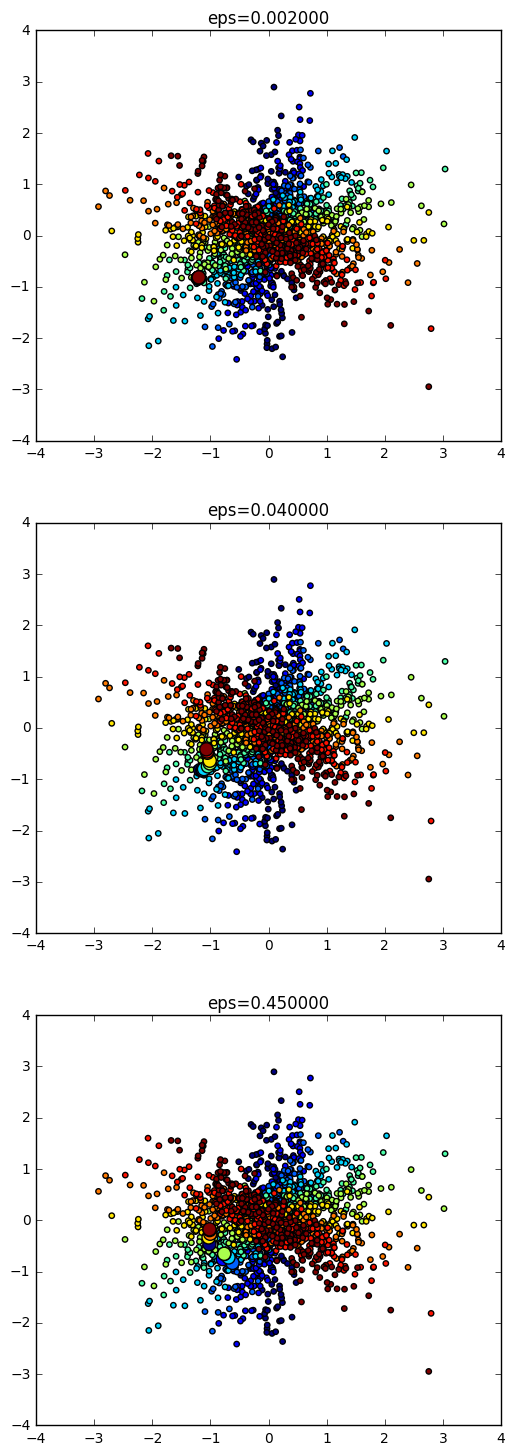

In [68]:
plt.figure(figsize=(6,18))
wlabel = np.arange(0,10)
j=0
for e in eps:
    plt.subplot(3,1,j+1)
    plt.title("eps=%f" % e )
    plt.scatter(dtonln[:,0],dtonln[:,1],15,label[0])
    plt.scatter(W[j][:,0],W[j][:,1],90,wlabel)
    j=j+1